In [1]:
import tensorflow as tf
assert tf.__version__ >= "2.16"

import keras_tuner as kt
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import cv2

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight

tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

2024-08-09 12:15:52.953118: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 12:15:53.027902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 12:15:53.044396: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 12:15:53.050966: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 12:15:53.093885: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#plot functions

plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

def plot_measure(history_train, history_test, title='', xticks=None):
    plt.figure(figsize=(12, 8))
    plt.plot(history_train, marker='o', markersize=5, label='Train')
    plt.plot(history_test, marker='o', markersize=5, label='Validation')
    plt.legend()
    if xticks is None:
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
    else:
        #plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax = plt.subplot(111)
        ax.set_xlim(xticks[0], xticks[-1])
        plt.xticks(xticks)
    plt.title(title)
    plt.show()

def plot_confusion_matrix(train_labels, predictions_train):
    plt.figure(figsize=(12,6))
    disp = ConfusionMatrixDisplay.from_predictions(train_labels, predictions_train, normalize='true', cmap='Blues')
    disp.figure_.suptitle("Confusion Matrix")
    plt.grid(None)
    plt.show()

In [3]:
def print_accuracy_scores(train_labels, test_labels, predictions_train_model, predictions_test_model):
    acc_train = accuracy_score(train_labels, predictions_train_model)
    acc_test = accuracy_score(test_labels, predictions_test_model)
    print('Training set accuracy:   {:.3f}'.format(acc_train))
    print('Test set accuracy:       {:.3f}'.format(acc_test))

def print_stats(labels, predictions, title):
    meas = precision_recall_fscore_support(labels, predictions, average=None, zero_division= np.nan)
    print(title)
    for i in range(2):
        print('Class {0:d}: precision={1:5.3f}, recall={2:5.3f}, f-measure={3:5.3f}'.format(i, meas[0][i], meas[1][i], meas[2][i]))

def train_validation_test_split(images, labels, test_val_size, verbose=False):
    train_images, test_val_images, train_labels, test_val_labels = train_test_split(images, labels, test_size=test_val_size, random_state=42)
    val_images, test_images, val_labels, test_labels = train_test_split(test_val_images, test_val_labels, test_size=0.5, random_state=42)

    if verbose:
        try:
            print(f'Shape of training set of images:    {train_images.shape}\t\timages of size {train_images.shape[1]}x{train_images.shape[2]}')
            print(f'Shape of validation set of images:  {val_images.shape}\t\timages of size {val_images.shape[1]}x{val_images.shape[2]}')
            print(f'Shape of test set of images:        {test_images.shape}\t\timages of size {test_images.shape[1]}x{test_images.shape[2]}')
            nb_classes = np.unique(train_labels).shape[0]
            print(f'Number of classes: {nb_classes}')
        except(IndexError):
            print(f'Shape of training set of images:    {train_images.shape}')
            print(f'Shape of validation set of images:  {val_images.shape}')
            print(f'Shape of test set of images:        {test_images.shape}')
            nb_classes = np.unique(train_labels).shape[0]
            print(f'Number of classes: {nb_classes}')

    return train_images, train_labels, val_images, val_labels, test_images, test_labels

In [4]:
X = np.load("pneumonia_images.npy")
y = (np.load("pneumonia_labels.npy")).ravel()

if (len(X) != len(y)):
    raise ValueError("Numbers of images and labels do not match")

print(f"The dataset is composed by {X.shape[0]} images {X.shape[1]}x{X.shape[2]}")

bin_count = np.bincount(y)
if len(bin_count) != 2:
    raise ValueError("Labels must be 0 or 1")

print("Negative examples: ", bin_count[0]) 
print("Positive examples: ", bin_count[1])

if bin_count[0] != bin_count[1]:
    print("Imbalanced Dataset")
else:
    print("Balanced Dataset")

x_negative = next((i for i, x in enumerate(X) if y[i] == 0), None)
x_positive = next((i for i, x in enumerate(X) if y[i] == 1), None)

The dataset is composed by 5232 images 28x28
Negative examples:  1349
Positive examples:  3883
Imbalanced Dataset


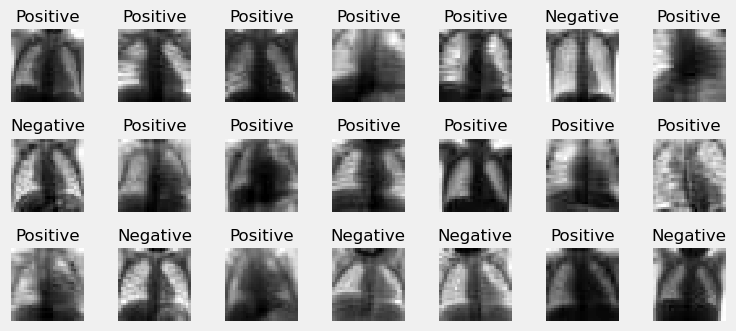

In [5]:
n_rows = 3
n_cols = 7
titles = ["Negative", "Positive"]
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(titles[y[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [6]:
def extract_histogram(image, color_space, channels=(0,1,2), bins=(8, 8, 8), range=(0, 256, 0, 256, 0, 256)):
    if color_space is None:
        cvt_img = image
    else:
        cvt_img = cv2.cvtColor(image, color_space)
    hist = cv2.calcHist([cvt_img], channels, None, bins, range)
    cv2.normalize(hist, hist)
    return hist.flatten()

def get_histograms(dataset, color_space, channels, bins, channels_range):
    histograms = []
    for x in dataset:
            hist = extract_histogram(x, color_space, channels, bins, channels_range)
            histograms.append(hist)
    return histograms

def ranges(N, nb):
    step = N / nb
    return ["{},{}".format(round(step*i), round(step*(i+1))) for i in range(nb)]

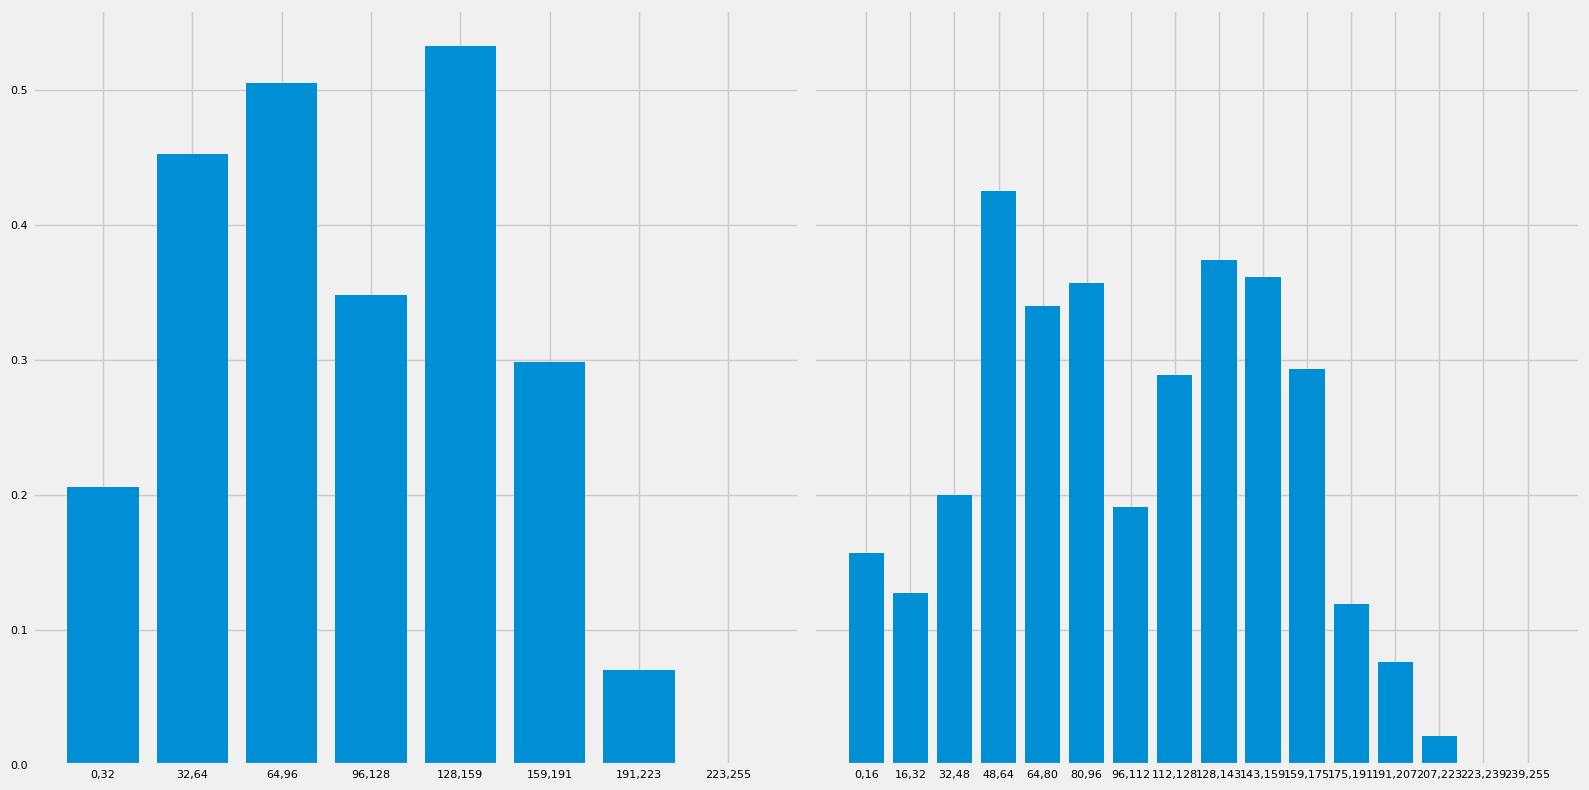

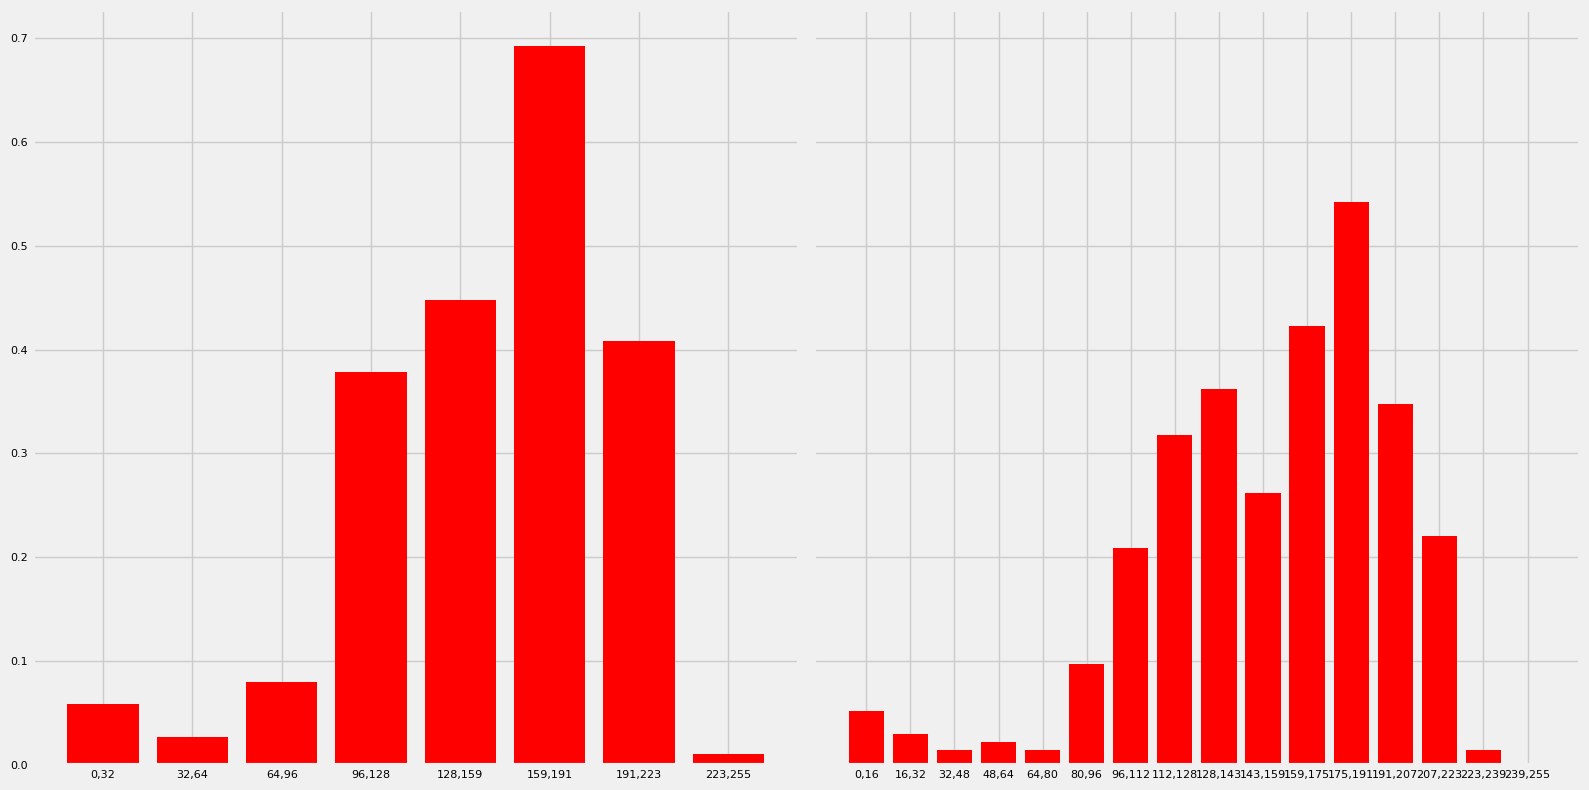

In [7]:
#negative
hist8bins = extract_histogram(X[x_negative], None, (0,), (8,), (0, 256))
hist16bins = extract_histogram(X[x_negative], None, (0,), (16,), (0, 256))
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].bar(ranges(255, 8), hist8bins)
axs[1].bar(ranges(255, 16), hist16bins)
plt.show()

#positive
hist8bins = extract_histogram(X[x_positive], None, (0,), (8,), (0, 256))
hist16bins = extract_histogram(X[x_positive], None, (0,), (16,), (0, 256))
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].bar(ranges(255, 8), hist8bins, color="red")
axs[1].bar(ranges(255, 16), hist16bins, color="red")
plt.show()

In [8]:
bins_8 = np.array(get_histograms(X, None, (0,), (8,), (0, 256)))
bins_16 = np.array(get_histograms(X, None, (0,), (16,), (0, 256)))

In [9]:
def build_logistic_regression(hp):
    model = LogisticRegression(
        random_state=42,
        class_weight='balanced',
        C=hp.Float("C", min_value=10e-6, max_value=0.1, step=10, sampling="log"),
        solver=hp.Choice("solver", ["liblinear", "saga"]),
        penalty= hp.Choice("penalty", ["l1", "l2"]))
    return model

In [10]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_logistic_regression,
    cv=StratifiedKFold(5),
    project_name='tuners/log_reg_hist_8bins')

X_train, X_test, y_train, y_test = train_test_split(bins_8, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest C: ", best_hps.get("C"))
print("\nBest solver: ", best_hps.get("solver"))
print("\nBest penalty: ", best_hps.get("penalty"))

print()

model0 = tuner.hypermodel.build(best_hps)
model0.fit(X_train, y_train)

predictions_test = model0.predict(X_test)
predictions_train = model0.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

Reloading Tuner from ./tuners/log_reg_hist_8bins/tuner0.json

Best C:  0.1

Best solver:  saga

Best penalty:  l1

Training set accuracy:   0.775
Test set accuracy:       0.768
Training set
Class 0: precision=0.542, recall=0.841, f-measure=0.659
Class 1: precision=0.931, recall=0.752, f-measure=0.832
Test set
Class 0: precision=0.527, recall=0.796, f-measure=0.635
Class 1: precision=0.917, recall=0.758, f-measure=0.830


In [11]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_logistic_regression,
    cv=StratifiedKFold(5),
    project_name='tuners/log_reg_hist_16bins')

X_train, X_test, y_train, y_test = train_test_split(bins_16, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest C: ", best_hps.get("C"))
print("\nBest solver: ", best_hps.get("solver"))
print("\nBest penalty: ", best_hps.get("penalty"))

print()

model0 = tuner.hypermodel.build(best_hps)
model0.fit(X_train, y_train)

predictions_test = model0.predict(X_test)
predictions_train = model0.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

Reloading Tuner from ./tuners/log_reg_hist_16bins/tuner0.json

Best C:  0.01

Best solver:  saga

Best penalty:  l1

Training set accuracy:   0.741
Test set accuracy:       0.747
Training set
Class 0: precision=  nan, recall=0.000, f-measure=0.000
Class 1: precision=0.741, recall=1.000, f-measure=0.851
Test set
Class 0: precision=  nan, recall=0.000, f-measure=0.000
Class 1: precision=0.747, recall=1.000, f-measure=0.855


In [12]:
def build_random_forest(hp):
    model = RandomForestClassifier(
        n_estimators=hp.Choice("n_estimators", [50, 100, 250]),
        criterion=hp.Choice("criterion", ["gini", "entropy"]),
        max_depth=hp.Choice("max_depth", [1, 5, 10, 15]),
        max_features=hp.Choice("max_features", ["sqrt", "log2"]),
        n_jobs=-1, 
        random_state=42)
    
    return model

In [13]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_random_forest,
    cv=StratifiedKFold(5),
    overwrite=False,
    project_name='tuners/random_forest_hist_8bins')

X_train, X_test, y_train, y_test = train_test_split(bins_8, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best n_estimators:       ", best_hps.get("n_estimators"))
print("Best criterion:          ", best_hps.get("criterion"))
print("Best max_depth:          ", best_hps.get("max_depth"))
print("Best max_features:       ", best_hps.get("max_features"))

print()

model0 = tuner.hypermodel.build(best_hps)
model0.fit(X_train, y_train)

predictions_test = model0.predict(X_test)
predictions_train = model0.predict(X_train)  

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

Reloading Tuner from ./tuners/random_forest_hist_8bins/tuner0.json
Best n_estimators:        100
Best criterion:           gini
Best max_depth:           10
Best max_features:        sqrt

Training set accuracy:   0.951
Test set accuracy:       0.878
Training set
Class 0: precision=0.935, recall=0.869, f-measure=0.901
Class 1: precision=0.955, recall=0.979, f-measure=0.967
Test set
Class 0: precision=0.822, recall=0.660, f-measure=0.732
Class 1: precision=0.892, recall=0.951, f-measure=0.921


In [14]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_random_forest,
    cv=StratifiedKFold(5),
    project_name='tuners/random_forest_hist_16bins')

X_train, X_test, y_train, y_test = train_test_split(bins_16, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best n_estimators:       ", best_hps.get("n_estimators"))
print("Best criterion:          ", best_hps.get("criterion"))
print("Best max_depth:          ", best_hps.get("max_depth"))
print("Best max_features:       ", best_hps.get("max_features"))

print()

model0 = tuner.hypermodel.build(best_hps)
model0.fit(X_train, y_train)

predictions_test = model0.predict(X_test)
predictions_train = model0.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

Reloading Tuner from ./tuners/random_forest_hist_16bins/tuner0.json
Best n_estimators:        250
Best criterion:           gini
Best max_depth:           10
Best max_features:        sqrt

Training set accuracy:   0.977
Test set accuracy:       0.897
Training set
Class 0: precision=0.961, recall=0.951, f-measure=0.956
Class 1: precision=0.983, recall=0.986, f-measure=0.985
Test set
Class 0: precision=0.831, recall=0.743, f-measure=0.785
Class 1: precision=0.916, recall=0.949, f-measure=0.932


In [15]:
def build_adaboost_trees(hp):
    model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            criterion=hp.Choice("criterion", ["gini", "entropy"]),
            max_depth=hp.Choice("max_depth", [1, 5, 10, 15]),
            random_state=42),
        n_estimators=hp.Choice("n_estimators", [50, 100, 250, 500]),
        learning_rate=hp.Choice("learning_rate", [0.001, 0.01, 0.1, 1.0, 10.0]),
        algorithm="SAMME",
        random_state=42)
    
    return model

In [16]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_adaboost_trees,
    cv=StratifiedKFold(5),
    project_name='tuners/adaboost_hist_8bins')

X_train, X_test, y_train, y_test = train_test_split(bins_8, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best criterion:          ", best_hps.get("criterion"))
print("Best max_depth:          ", best_hps.get("max_depth"))
print("Best n_estimators:       ", best_hps.get("n_estimators"))
print("Best learning_rate:      ", best_hps.get("learning_rate"))

print()

model0 = tuner.hypermodel.build(best_hps)
model0.fit(X_train, y_train)

predictions_test = model0.predict(X_test)
predictions_train = model0.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

Reloading Tuner from ./tuners/adaboost_hist_8bins/tuner0.json
Best criterion:           gini
Best max_depth:           2
Best n_estimators:        250
Best learning_rate:       10.0

Training set accuracy:   0.859
Test set accuracy:       0.849
Training set
Class 0: precision=0.855, recall=0.546, f-measure=0.667
Class 1: precision=0.859, recall=0.968, f-measure=0.910
Test set
Class 0: precision=0.850, recall=0.491, f-measure=0.622
Class 1: precision=0.849, recall=0.971, f-measure=0.906


In [17]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_adaboost_trees,
    cv=StratifiedKFold(5),
    project_name='tuners/adaboost_hist_16bins')

X_train, X_test, y_train, y_test = train_test_split(bins_16, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best criterion:          ", best_hps.get("criterion"))
print("Best max_depth:          ", best_hps.get("max_depth"))
print("Best n_estimators:       ", best_hps.get("n_estimators"))
print("Best learning_rate:      ", best_hps.get("learning_rate"))

print()

model0 = tuner.hypermodel.build(best_hps)
model0.fit(X_train, y_train)

predictions_test = model0.predict(X_test)
predictions_train = model0.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

Reloading Tuner from ./tuners/adaboost_hist_16bins/tuner0.json
Best criterion:           gini
Best max_depth:           5
Best n_estimators:        500
Best learning_rate:       0.01

Training set accuracy:   0.916
Test set accuracy:       0.887
Training set
Class 0: precision=0.853, recall=0.816, f-measure=0.834
Class 1: precision=0.937, recall=0.951, f-measure=0.944
Test set
Class 0: precision=0.800, recall=0.740, f-measure=0.769
Class 1: precision=0.914, recall=0.937, f-measure=0.926


In [18]:
f1_score = tf.keras.metrics.F1Score("weighted")
obj_f1_score = kt.Objective("val_f1_score", "max")

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min", patience = 3)

shape = X.shape
X = np.reshape(X, (shape[0], shape[1], shape[2], 1))

X_train, y_train, X_valid, y_valid, X_test, y_test = train_validation_test_split(X, y, 0.3, 1)
classes = np.unique(y_train).shape[0]
y_train_onehot = tf.keras.utils.to_categorical(y_train, classes)
y_valid_onehot = tf.keras.utils.to_categorical(y_valid, classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, classes)

Shape of training set of images:    (3662, 28, 28, 1)		images of size 28x28
Shape of validation set of images:  (785, 28, 28, 1)		images of size 28x28
Shape of test set of images:        (785, 28, 28, 1)		images of size 28x28
Number of classes: 2


In [19]:
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))
  
class_weights = generate_class_weights(y_train)

In [20]:
def f1_weighted_loss(true, pred): #shapes (batch, 4)

    #for metrics include these two lines, for loss, don't include them
    #these are meant to round 'pred' to exactly zeros and ones
    #predLabels = K.argmax(pred, axis=-1)
    #pred = K.one_hot(predLabels, 4) 


    ground_positives = tf.keras.ops.sum(true, axis=0) + tf.keras.backend.epsilon()       # = TP + FN
    pred_positives = tf.keras.ops.sum(pred, axis=0) + tf.keras.backend.epsilon()         # = TP + FP
    true_positives = tf.keras.ops.sum(true * pred, axis=0) + tf.keras.backend.epsilon()  # = TP
        #all with shape (4,)
    
    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
        #both = 1 if ground_positives == 0 or pred_positives == 0
        #shape (4,)

    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        #still with shape (4,)

    weighted_f1 = f1 * ground_positives / tf.keras.ops.sum(ground_positives) 
    weighted_f1 = tf.keras.ops.sum(weighted_f1)

    
    return 1 - weighted_f1 #for metrics, return only 'weighted_f1'


In [21]:
filters = [[16,32,64], [32, 64, 128], [64, 128, 256], [128, 256, 512]]
dense_units = [[32, 64], [64, 128], [128, 256], [256, 512]]
l2 = [0.01, 0.001, 0.0001, 0.00001]
activations = ["relu", "leaky_relu", "tanh"]

In [22]:
def model0_builder(hp): 
    filters_index = hp.Int("filters_index", min_value=0, max_value=2, step=1)
    dense_units_index = hp.Int("dense_index", min_value=0, max_value=2, step=1)
    activation = hp.Choice("activations", activations)
    k = hp.Choice("L2", l2)
    dropout_rate = hp.Float("dropout_rate", min_value=0.0, max_value=0.5, step=.05)
    spatial_dropout_rate = hp.Float("spatial_dropout_rate", min_value=0.0, max_value=0.5, step=.05)
    batch_norm = hp.Boolean("batch_norm")

    model0 = tf.keras.Sequential()
    
    model0.add(tf.keras.layers.InputLayer((28, 28, 1)))
    model0.add(tf.keras.layers.Rescaling(1./255))
    model0.add(tf.keras.layers.GaussianNoise(0.2))

    model0.add(tf.keras.layers.Conv2D(filters[filters_index][0], 3, padding='same', activation=activation))
    if batch_norm:
        model0.add(tf.keras.layers.BatchNormalization())
    model0.add(tf.keras.layers.MaxPool2D())
    model0.add(tf.keras.layers.SpatialDropout2D(spatial_dropout_rate))
    
    model0.add(tf.keras.layers.Conv2D(filters[filters_index][1], 3, padding='same', activation=activation))
    if batch_norm:
        model0.add(tf.keras.layers.BatchNormalization())
    model0.add(tf.keras.layers.MaxPool2D())
    model0.add(tf.keras.layers.SpatialDropout2D(spatial_dropout_rate))
   
    model0.add(tf.keras.layers.Conv2D(filters[filters_index][2], 3, padding='same', activation=activation))
    if batch_norm:
        model0.add(tf.keras.layers.BatchNormalization())
    model0.add(tf.keras.layers.MaxPool2D())
    model0.add(tf.keras.layers.SpatialDropout2D(spatial_dropout_rate))
  
    model0.add(tf.keras.layers.Flatten())

    model0.add(tf.keras.layers.Dense(dense_units[dense_units_index][0], activation=activation, kernel_regularizer=tf.keras.regularizers.L2(k)))
    model0.add(tf.keras.layers.Dropout(dropout_rate))

    model0.add(tf.keras.layers.Dense(dense_units[dense_units_index][1], activation=activation, kernel_regularizer=tf.keras.regularizers.L2(k)))
    model0.add(tf.keras.layers.Dropout(dropout_rate))
        
    model0.add(tf.keras.layers.Dense(classes, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.L2(k)))
    
    model0.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score])

    return model0

In [23]:
tuner = kt.Hyperband(model0_builder, obj_f1_score, max_epochs=25, project_name='tuners/cnn0', seed=42)
tuner.search(X_train, y_train_onehot, batch_size=128, validation_data=(X_valid, y_valid_onehot), callbacks=[early_stop], class_weight=class_weights, verbose=0)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

I0000 00:00:1723198572.489798    1796 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723198572.635220    1796 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723198572.640149    1796 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723198572.644990    1796 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [24]:
print("Best Filter: ", filters[best_hps.get("filters_index")])
print("Best Dense units: ", dense_units[best_hps.get("dense_index")])
print("Best Activations Functions: ", best_hps.get("activations"))
print("Best L2 value: ",  best_hps.get("L2"))

if best_hps.get("spatial_dropout_rate") > 0:
    print("Best SpatialDropout2D Rate: ", best_hps.get("spatial_dropout_rate")) 

if best_hps.get("dropout_rate") > 0:
    print("Best Dropout Rate: ", best_hps.get("dropout_rate"))

model0 = tuner.hypermodel.build(best_hps)
model0.summary()

Best Filter:  [64, 128, 256]
Best Dense units:  [128, 256]
Best Activations Functions:  relu
Best L2 value:  0.001
Best SpatialDropout2D Rate:  0.05
Best Dropout Rate:  0.25


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 28, 28, 1)      │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (None, 14, 14, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_4             │ (None, 7, 7, 128)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_5             │ (None, 3, 3, 256)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 698,242 (2.66 MB)

 Trainable params: 698,242 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

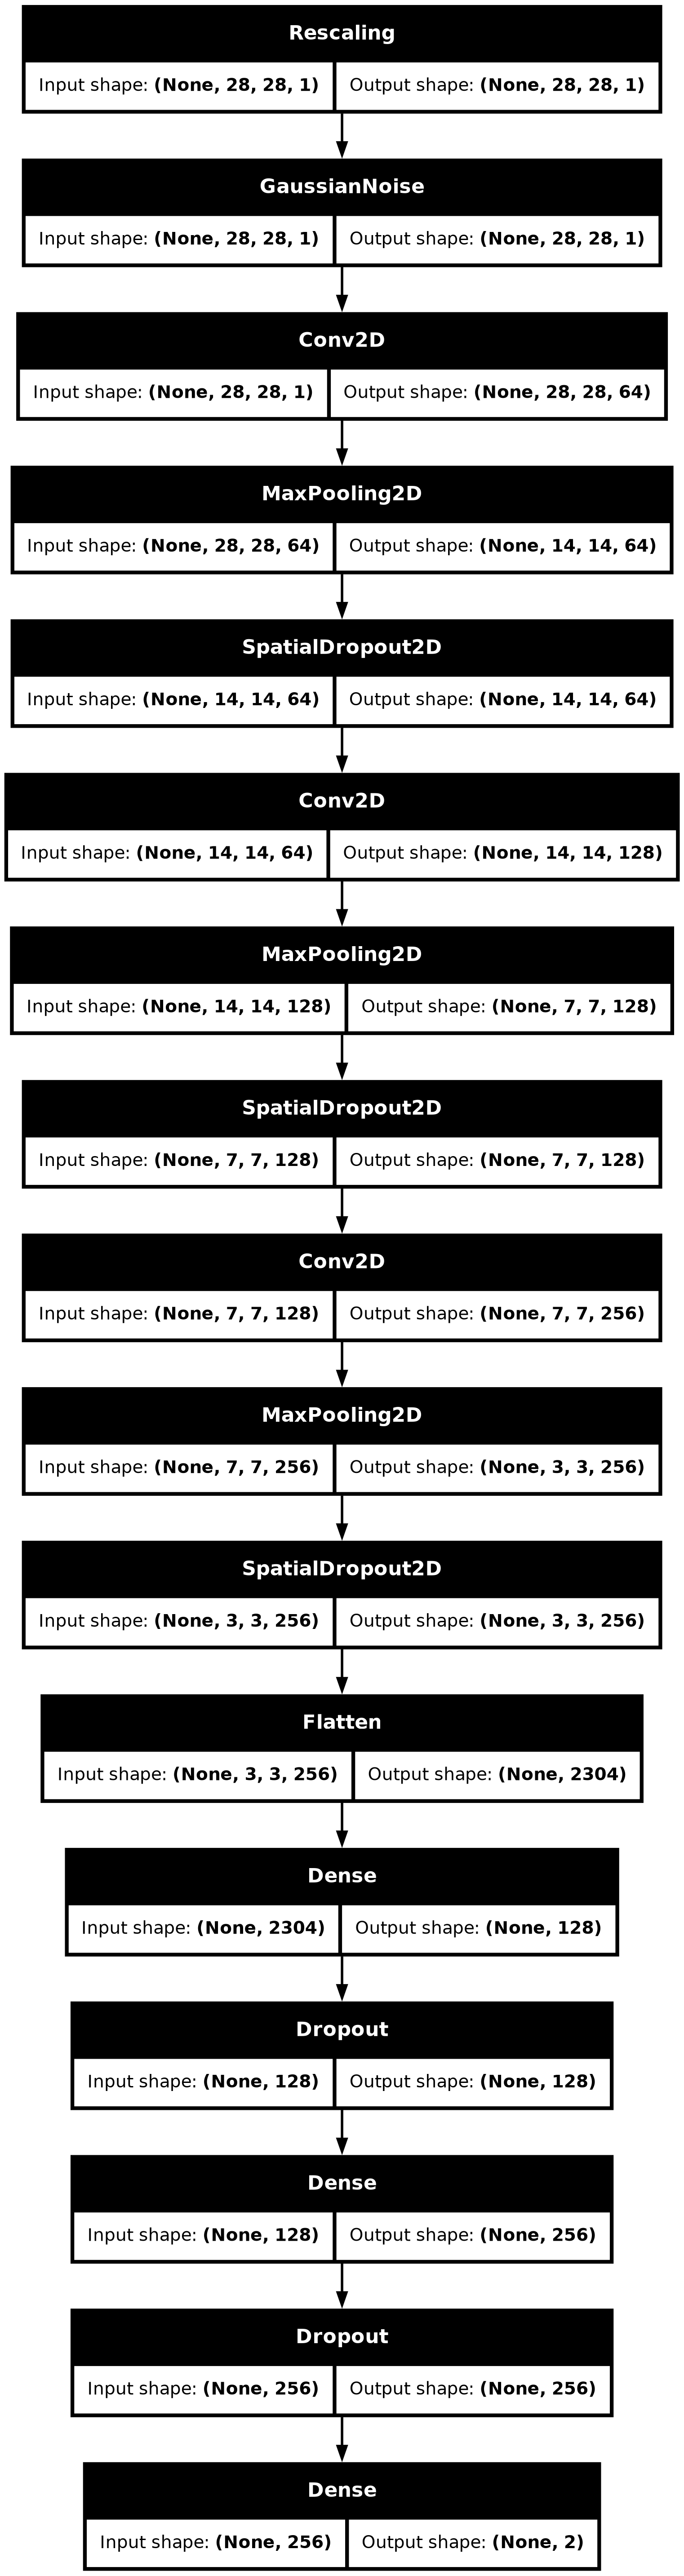

In [25]:
tf.keras.utils.plot_model(model0, "model0.png", show_shapes=True)

In [26]:
model_file = "./best_model/model0.weights.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, "val_f1_score", 1, True, True, "max")
history_model0 = model0.fit(X_train, y_train_onehot, batch_size=128, epochs=20, verbose=1, validation_data=(X_valid, y_valid_onehot), 
                            callbacks=[early_stop, checkpoint], class_weight=class_weights)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - f1_score: 0.6893 - loss: 1.0292
Epoch 1: val_f1_score improved from -inf to 0.68735, saving model to ./best_model/model0.weights.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - f1_score: 0.6864 - loss: 1.0271 - val_f1_score: 0.6874 - val_loss: 0.8052
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - f1_score: 0.8079 - loss: 0.6598
Epoch 2: val_f1_score improved from 0.68735 to 0.92378, saving model to ./best_model/model0.weights.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - f1_score: 0.8088 - loss: 0.6557 - val_f1_score: 0.9238 - val_loss: 0.3206
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - f1_score: 0.8917 - loss: 0.3475
Epoch 3: val_f1_score improved from 0.92378 to 0.93092, saving model to ./best_model/model0.weights.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - f1_score: 0.8919 - loss: 0.3470 - val_f1_score: 0.9309 - val_loss: 0.2394
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - f1_score: 0.9157 - loss: 0.2817
Epo

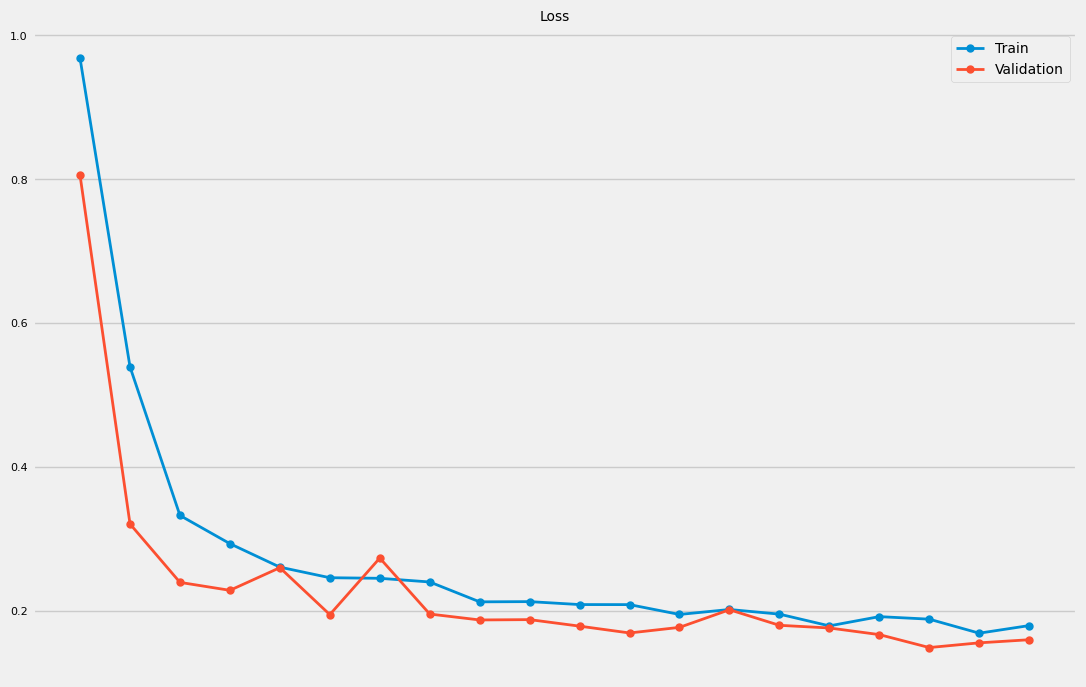

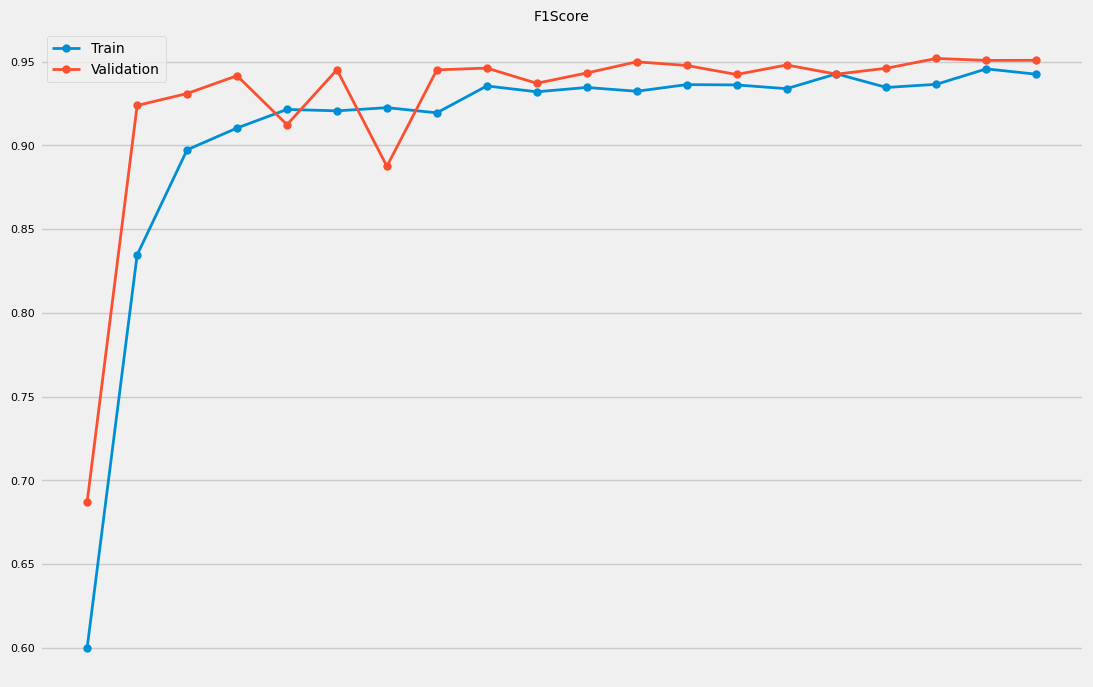

115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


<Figure size 1200x600 with 0 Axes>

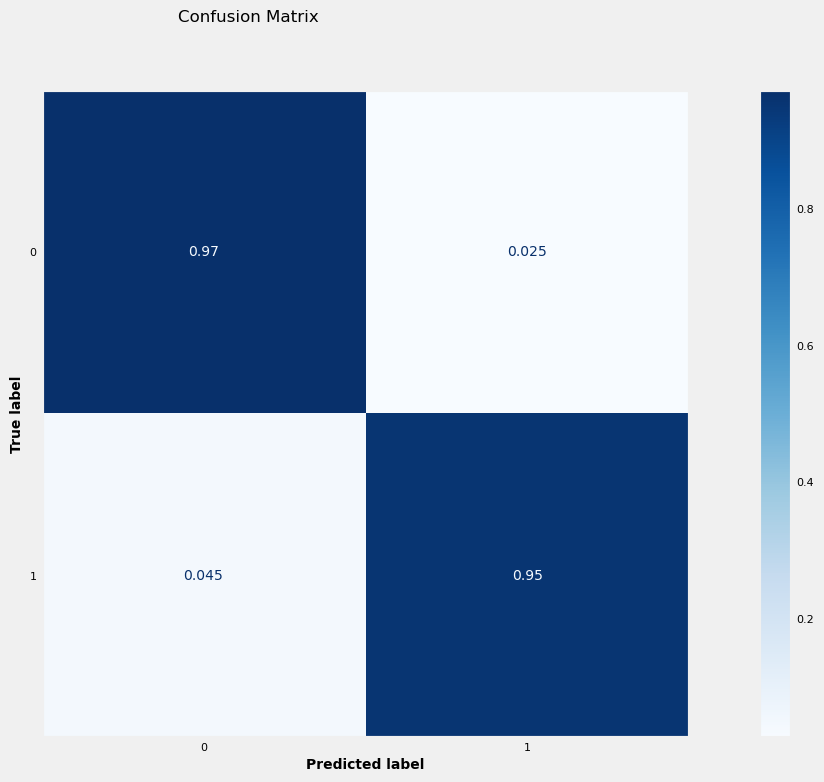

<Figure size 1200x600 with 0 Axes>

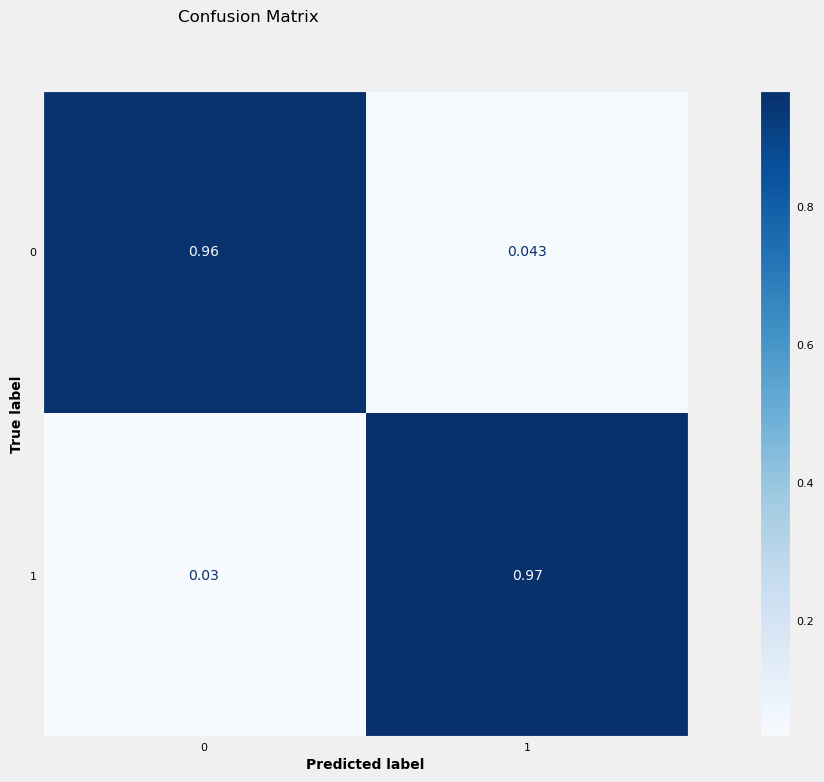

Training set accuracy:   0.960
Test set accuracy:       0.967
Training set
Class 0: precision=0.882, recall=0.975, f-measure=0.926
Class 1: precision=0.991, recall=0.955, f-measure=0.972
Test set
Class 0: precision=0.909, recall=0.957, f-measure=0.932
Class 1: precision=0.986, recall=0.970, f-measure=0.978


In [27]:
history_model0_df = pd.DataFrame(history_model0.history)
plot_measure(history_model0_df.loss, history_model0_df.val_loss, 'Loss')
plot_measure(history_model0_df.f1_score, history_model0_df.val_f1_score, 'F1Score')

model0.load_weights(model_file)
predictions_train_model0 = np.argmax(model0.predict(X_train), axis=-1)
predictions_test_model0 = np.argmax(model0.predict(X_test), axis=-1)

plot_confusion_matrix(y_train, predictions_train_model0)
plot_confusion_matrix(y_test, predictions_test_model0)

print_accuracy_scores(y_train, y_test, predictions_train_model0, predictions_test_model0)
print_stats(y_train, predictions_train_model0, "Training set")
print_stats(y_test, predictions_test_model0, "Test set")